#Thyroid Disease Classification - A Comparative analysis of Random Forest, XGBoost, Ensemble Learning and Neural Networks

1. Firstly an EDA was performed, in which dataset and its features were explored by multiple aspects.
2. Then, performance of multiple ML models with and without using class balance (Using SMOTE), was compared.
3. Lastly feature importance was analyzed using LIME and SHAP methods.


# 1. Importing & Installing Required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from numpy import where
from collections import Counter
from matplotlib import pyplot

In [ ]:
%cd /content/drive/MyDrive/CodeWorks/Libs

/content/drive/MyDrive/CodeWorks/Libs


In [ ]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283838 sha256=2cfeb3dd25e8f46fb319cdf69b1161455e3455c2eedacfa725fa9fe87bcdd201
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import shap
import lime

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#2. Reading Dataset

In [ ]:

# read the csv file with column names
df = pd.read_csv('/content/drive/MyDrive/CodeWorks/ThyroidClassification/hypothyroid.csv')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [ ]:
df

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,f,?,other,P
3768,68,F,f,f,f,f,f,f,f,f,...,t,124,t,1.08,t,114,f,?,SVI,P
3769,74,F,f,f,f,f,f,f,f,f,...,t,112,t,1.07,t,105,f,?,other,P
3770,72,M,f,f,f,f,f,f,f,f,...,t,82,t,0.94,t,87,f,?,SVI,P


As we can see, original dataset has 3772 rows and 30 columns (features). We'll train our models on selected features.

#3. Data Preprocessing & Analysis

1. Chaning target label name

In [ ]:
df.rename(columns={'binaryClass':'thyroid_presence'},inplace=True)
df.replace('?',np.nan,inplace=True)

Converting features from object to numeric enables us to analyze their minimum, mean, and maximum values. Additionally, for categorical features like Age and Gender, we assess the distribution of true and false values, revealing instances of value imbalance across various features.

Our following initial EDA reveals that some features exhibit significantly higher true values, while others have more false values, indicating potential disparities in the dataset.

In [ ]:
numeric_fields = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
categorical_fields = [col for col in df.columns if col not in numeric_fields]
categorical_fields.remove('TBG')

# Convert numeric fields to numeric type
for col in numeric_fields:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert categorical fields to category type
for col in categorical_fields:
    df[col] = df[col].astype('category')

# Display the basic information about the dataframe
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3771 non-null   float64 
 1   sex                        3622 non-null   category
 2   on thyroxine               3772 non-null   category
 3   query on thyroxine         3772 non-null   category
 4   on antithyroid medication  3772 non-null   category
 5   sick                       3772 non-null   category
 6   pregnant                   3772 non-null   category
 7   thyroid surgery            3772 non-null   category
 8   I131 treatment             3772 non-null   category
 9   query hypothyroid          3772 non-null   category
 10  query hyperthyroid         3772 non-null   category
 11  lithium                    3772 non-null   category
 12  goitre                     3772 non-null   category
 13  tumor                      3772 n

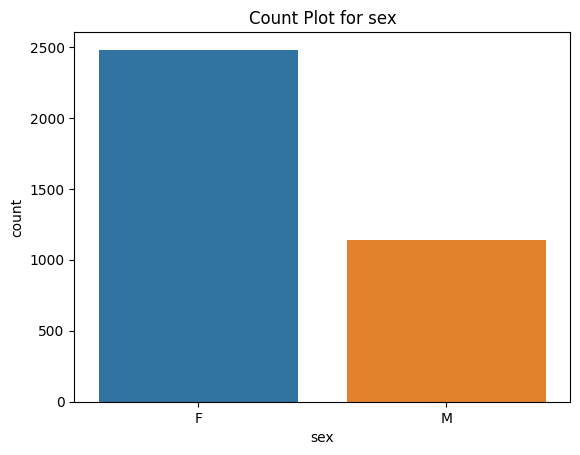

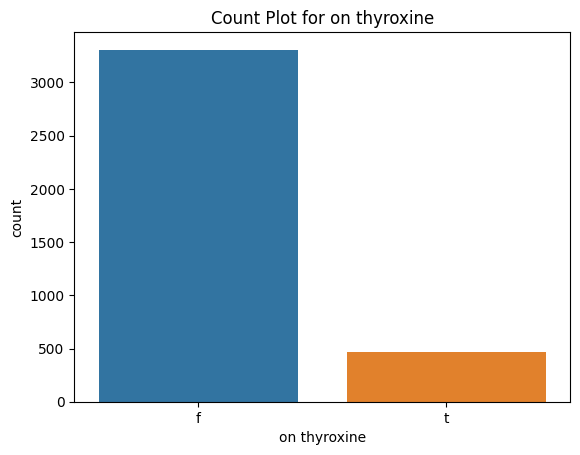

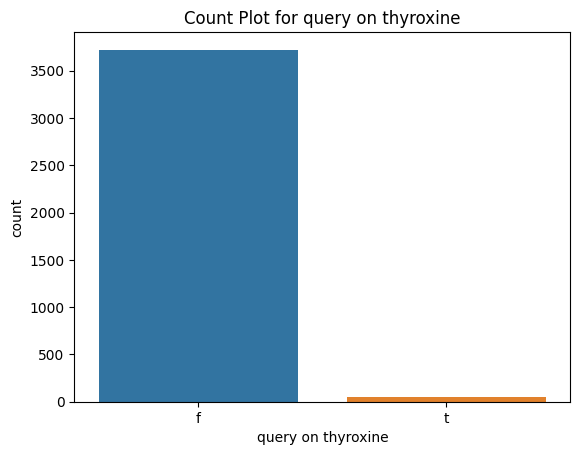

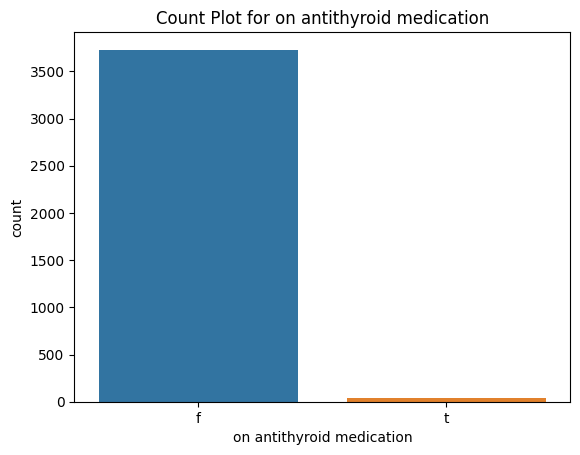

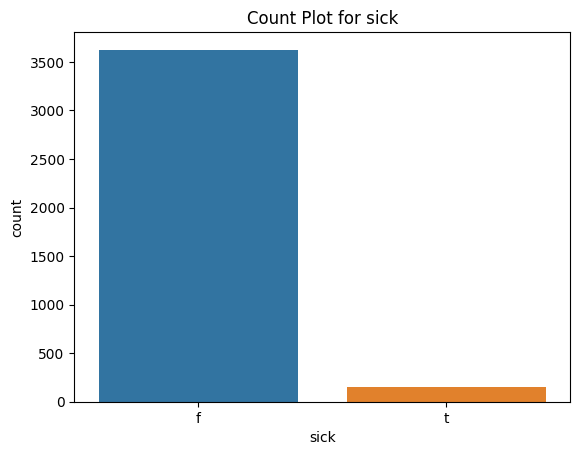

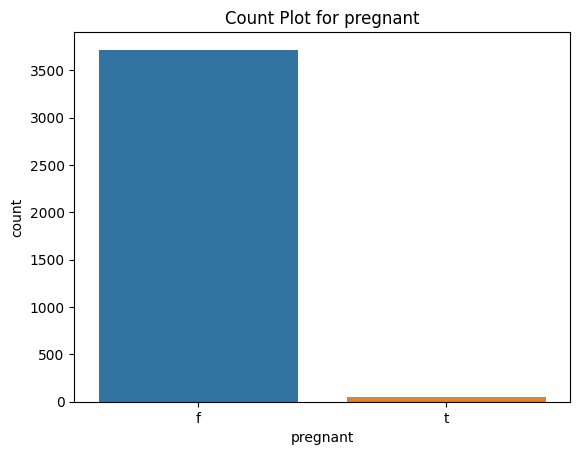

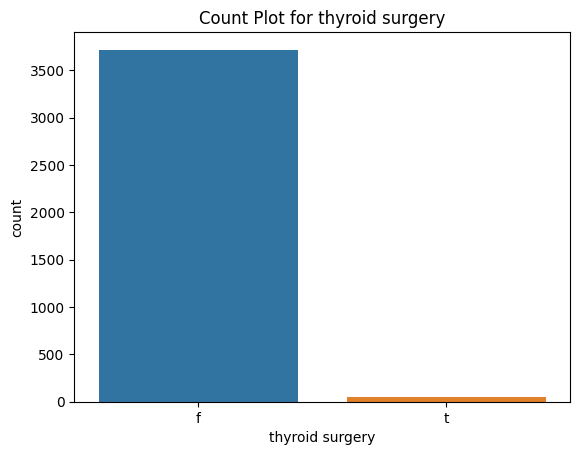

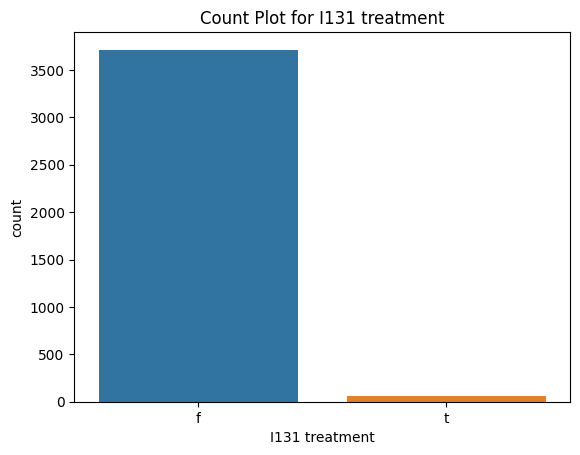

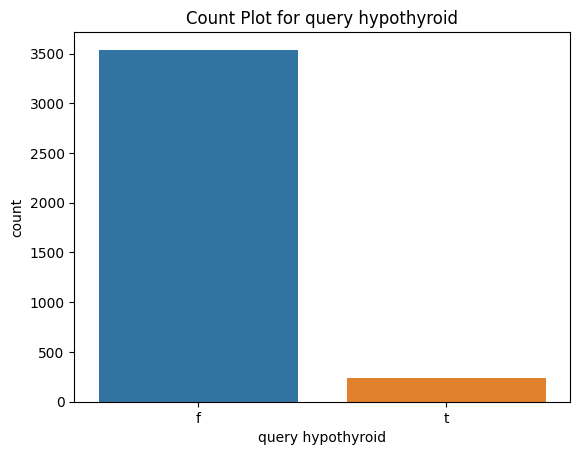

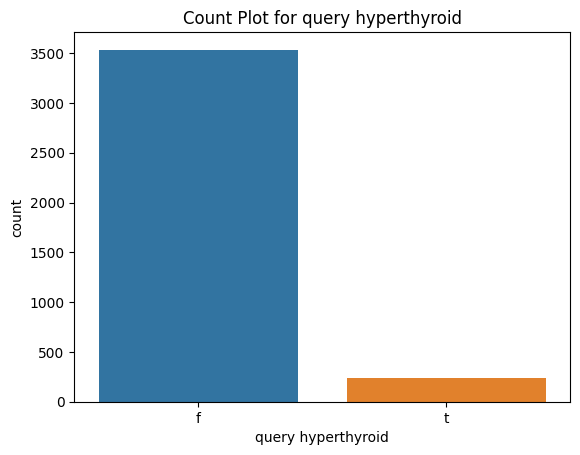

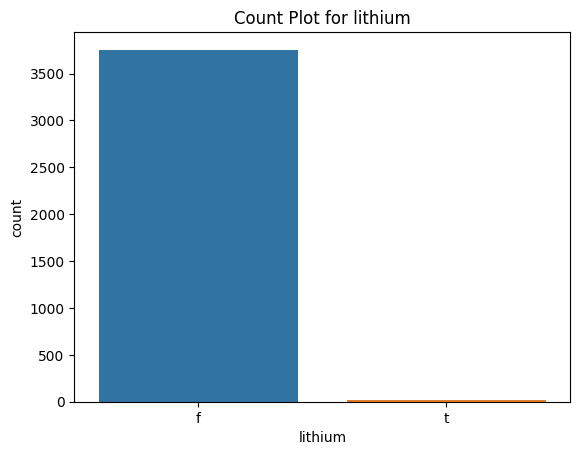

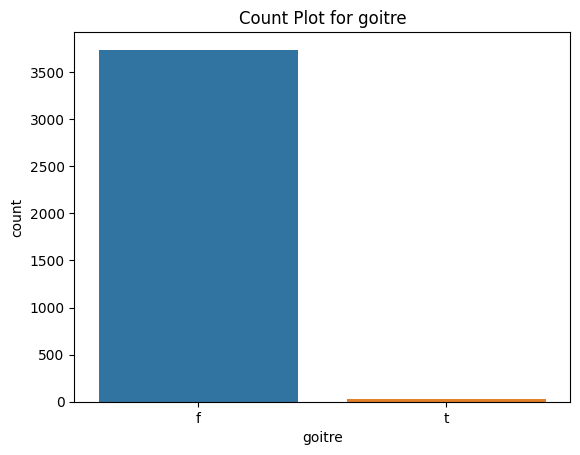

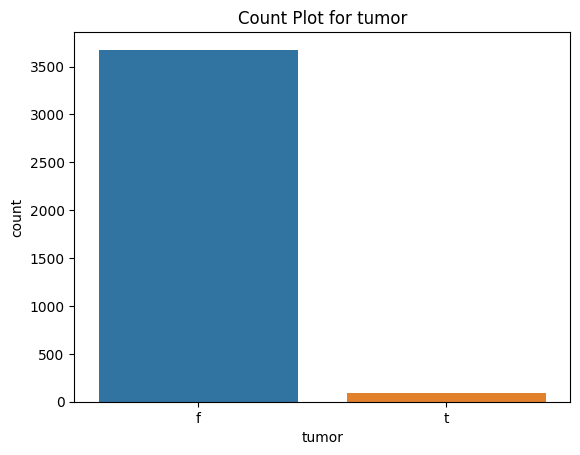

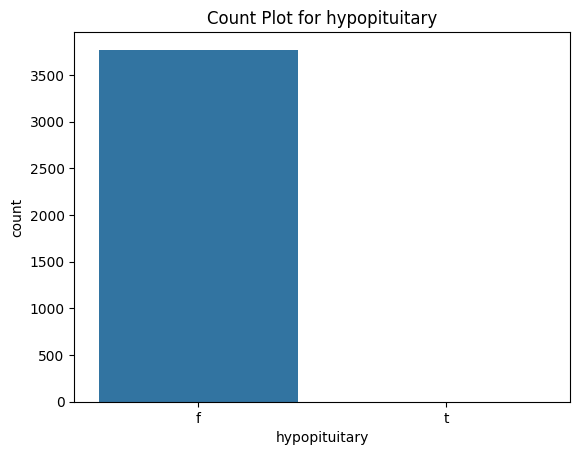

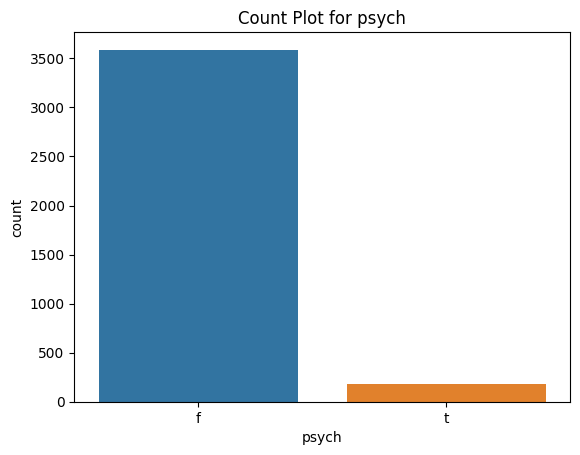

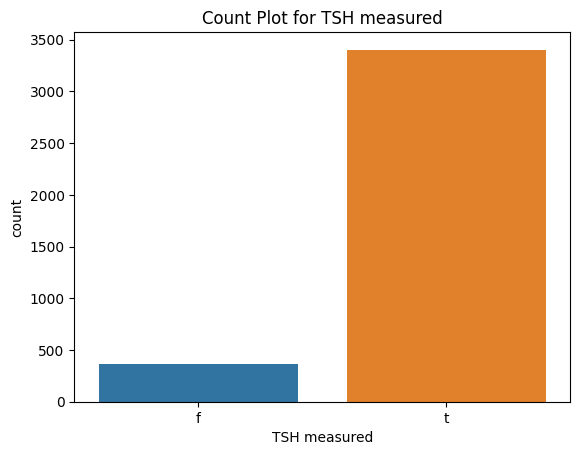

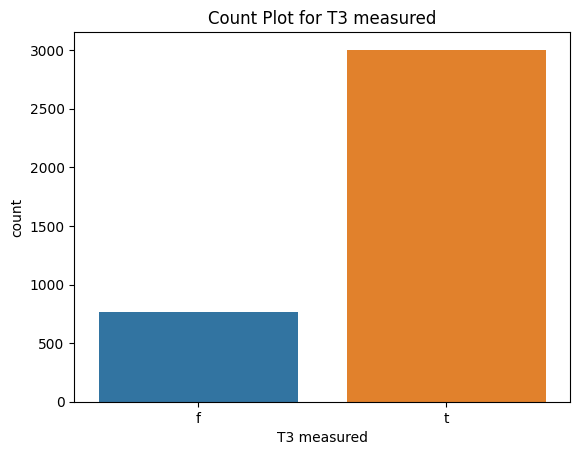

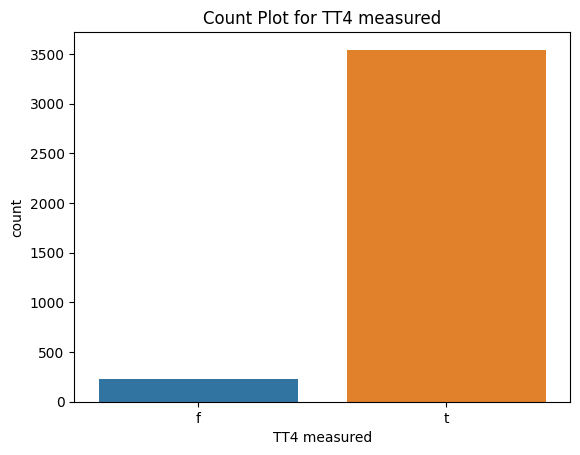

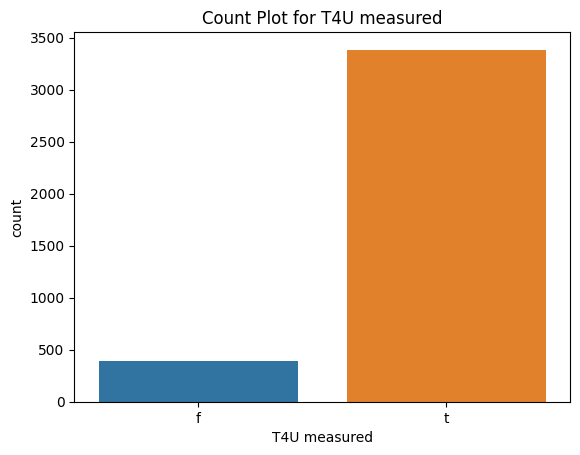

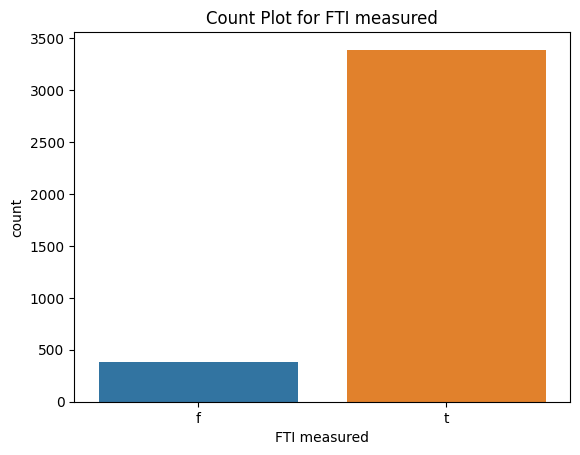

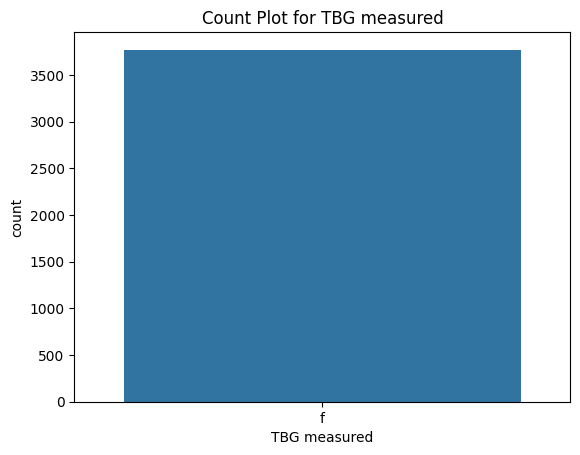

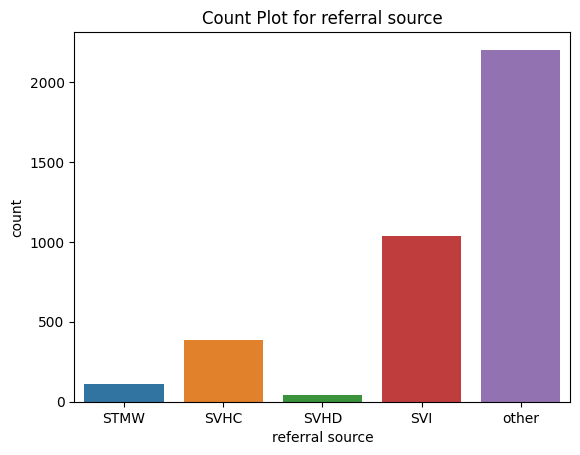

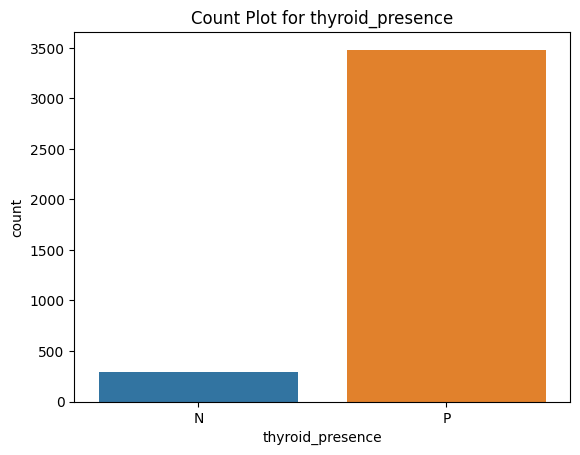

In [ ]:
# For each categorical field, showing a countplot
for i, col in enumerate(categorical_fields):
    plt.figure(i)
    sns.countplot(x=col, data=df)
    plt.title(f'Count Plot for {col}')
    plt.show()

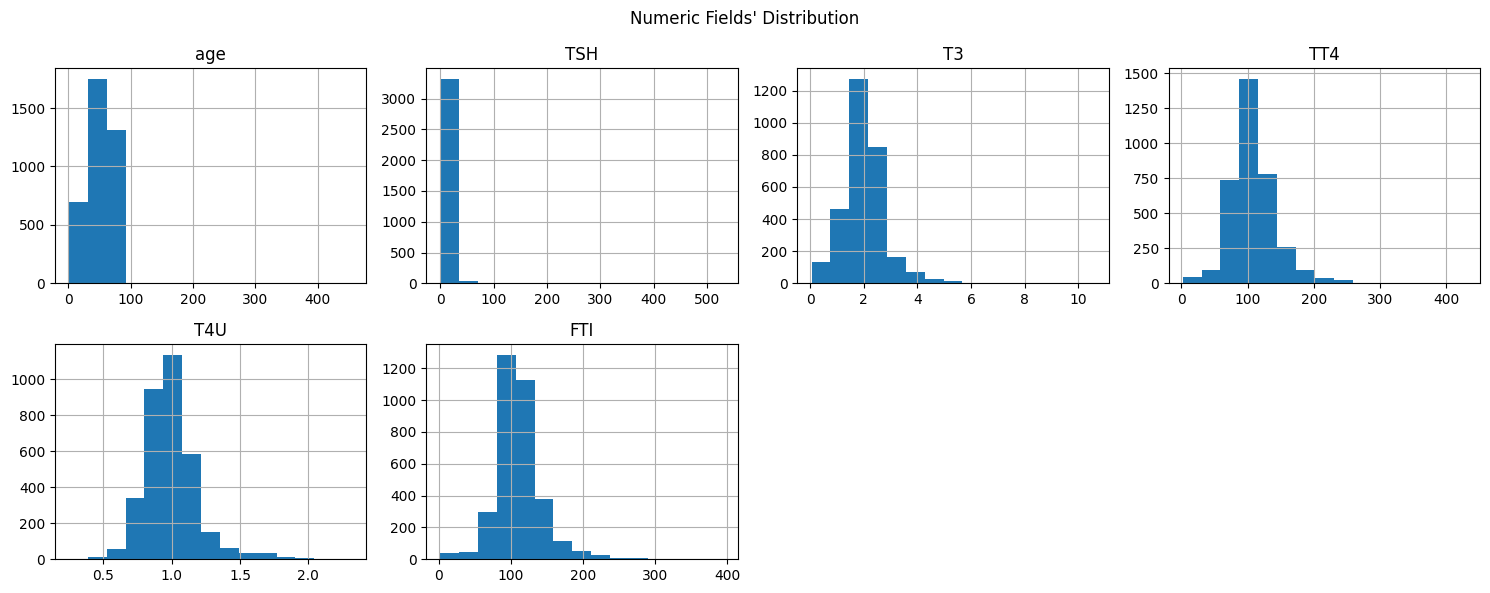

In [ ]:
# For numeric fields, show histograms
df[numeric_fields].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.suptitle('Numeric Fields\' Distribution')
plt.tight_layout()
plt.show()

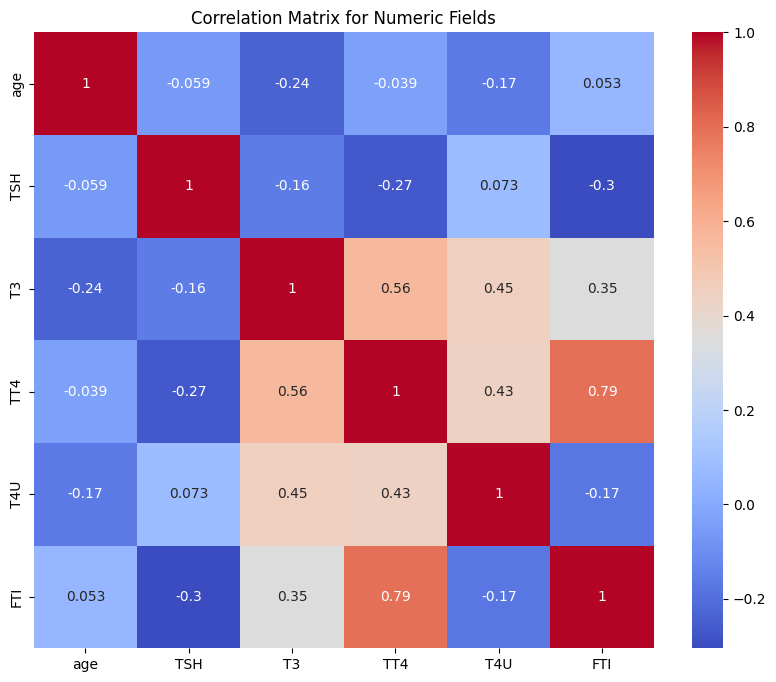

In [ ]:
# Correlation matrix of numerical values
corr = df[numeric_fields].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Fields')
plt.show()

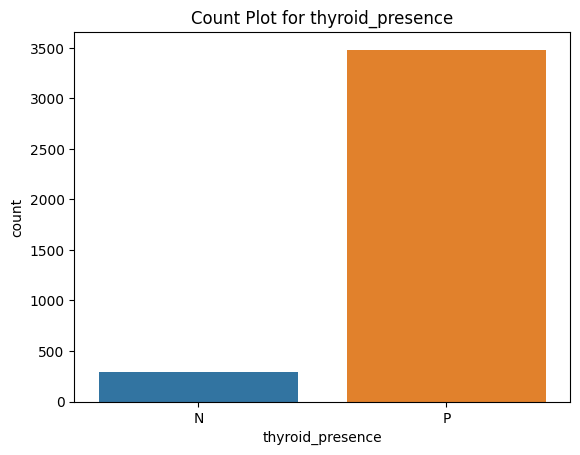

In [ ]:
# For thyroid_presence field specifically, show a countplot
sns.countplot(x='thyroid_presence', data=df)
plt.title('Count Plot for thyroid_presence')
plt.show()


Note: We can see that there is class imbalance problem in dataset.

We made a new dataframe that consists of commonly used features for Thyroid Classification

In [ ]:
df_eda = df.copy()

df_eda.drop(['T3 measured', 'TSH measured', 'TT4 measured', 'T4U measured', 'FTI measured', 'TBG measured',
             'TBG', 'referral source', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
             'query hypothyroid', 'query hyperthyroid', 'hypopituitary', 'psych'], axis=1, inplace=True)

In [ ]:
df_eda

,age,sex,sick,pregnant,thyroid surgery,I131 treatment,lithium,goitre,tumor,TSH,T3,TT4,T4U,FTI,thyroid_presence
0,41.0,F,f,f,f,f,f,f,f,1.30,2.5,125.0,1.14,109.0,P
1,23.0,F,f,f,f,f,f,f,f,4.10,2.0,102.0,NaN,NaN,P
2,46.0,M,f,f,f,f,f,f,f,0.98,NaN,109.0,0.91,120.0,P
3,70.0,F,f,f,f,f,f,f,f,0.16,1.9,175.0,NaN,NaN,P
4,70.0,F,f,f,f,f,f,f,f,0.72,1.2,61.0,0.87,70.0,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,F,f,f,f,f,f,f,t,NaN,NaN,NaN,NaN,NaN,P
3768,68.0,F,f,f,f,f,f,f,f,1.00,2.1,124.0,1.08,114.0,P
3769,74.0,F,f,f,f,f,f,f,f,5.10,1.8,112.0,1.07,105.0,P
3770,72.0,M,f,f,f,f,f,f,f,0.70,2.0,82.0,0.94,87.0,P


Preprocessing new dataframe - df_eda

In [ ]:
cols = ['age','FTI','TSH','T3','TT4','T4U']
for i in cols:
    df_eda[i] = pd.to_numeric(df_eda[i])

In [ ]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               3771 non-null   float64 
 1   sex               3622 non-null   category
 2   sick              3772 non-null   category
 3   pregnant          3772 non-null   category
 4   thyroid surgery   3772 non-null   category
 5   I131 treatment    3772 non-null   category
 6   lithium           3772 non-null   category
 7   goitre            3772 non-null   category
 8   tumor             3772 non-null   category
 9   TSH               3403 non-null   float64 
 10  T3                3003 non-null   float64 
 11  TT4               3541 non-null   float64 
 12  T4U               3385 non-null   float64 
 13  FTI               3387 non-null   float64 
 14  thyroid_presence  3772 non-null   category
dtypes: category(9), float64(6)
memory usage: 211.2 KB


Removing instances with null attributes

In [ ]:
df_eda.isnull().sum()

age                   1
sex                 150
sick                  0
pregnant              0
thyroid surgery       0
I131 treatment        0
lithium               0
goitre                0
tumor                 0
TSH                 369
T3                  769
TT4                 231
T4U                 387
FTI                 385
thyroid_presence      0
dtype: int64

In [ ]:
miss_cols = ['FTI','TSH','T3','TT4','T4U']
for i in miss_cols:
    df_eda[i] = df_eda[i].fillna(df_eda[i].mean())


In [ ]:
df_eda.dropna(inplace=True)

In [ ]:
df_eda.isnull().sum()

age                 0
sex                 0
sick                0
pregnant            0
thyroid surgery     0
I131 treatment      0
lithium             0
goitre              0
tumor               0
TSH                 0
T3                  0
TT4                 0
T4U                 0
FTI                 0
thyroid_presence    0
dtype: int64

In [ ]:
print(df_eda.describe())

               age          TSH           T3          TT4          T4U  \
count  3621.000000  3621.000000  3621.000000  3621.000000  3621.000000   
mean     51.840099     5.013970     2.011377   108.207981     0.995512   
std      20.094311    22.429801     0.738867    34.525348     0.185211   
min       1.000000     0.005000     0.050000     2.000000     0.250000   
25%      36.000000     0.600000     1.700000    89.000000     0.890000   
50%      54.000000     1.600000     2.013500   106.000000     0.995000   
75%      67.000000     3.700000     2.200000   123.000000     1.070000   
max     455.000000   530.000000    10.600000   430.000000     2.320000   

               FTI  
count  3621.000000  
mean    110.282939  
std      31.162471  
min       2.000000  
25%      94.000000  
50%     110.000000  
75%     122.000000  
max     395.000000  


We observe that highest age is 455. It is an outlier and seems to be a mistake. We'll find that instance and delete it.

In [ ]:
highest_age_index = df_eda['age'].idxmax()
print(highest_age_index)

1364


In [ ]:
df_eda.loc[1364]

age                 455.0
sex                     F
sick                    f
pregnant                f
thyroid surgery         f
I131 treatment          f
lithium                 f
goitre                  f
tumor                   f
TSH                   1.1
T3                    2.0
TT4                 118.0
T4U                  1.13
FTI                 104.0
thyroid_presence        P
Name: 1364, dtype: object

In [ ]:
df_eda = df_eda.drop(1364)

#4. Exploratory Data Analysis of new Dataframe - eda_df

In [ ]:
print(df_eda.info())
print(df_eda.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620 entries, 0 to 3771
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               3620 non-null   float64 
 1   sex               3620 non-null   category
 2   sick              3620 non-null   category
 3   pregnant          3620 non-null   category
 4   thyroid surgery   3620 non-null   category
 5   I131 treatment    3620 non-null   category
 6   lithium           3620 non-null   category
 7   goitre            3620 non-null   category
 8   tumor             3620 non-null   category
 9   TSH               3620 non-null   float64 
 10  T3                3620 non-null   float64 
 11  TT4               3620 non-null   float64 
 12  T4U               3620 non-null   float64 
 13  FTI               3620 non-null   float64 
 14  thyroid_presence  3620 non-null   category
dtypes: category(9), float64(6)
memory usage: 230.9 KB
None
               ag

After preprocessing, our dataset contains 3620 instance now

Converting Age, TT4 and FTI to int

In [ ]:
df_eda.TT4 = df_eda.TT4.astype(int)
df_eda.FTI = df_eda.FTI.astype(int)
df_eda.age = df_eda.age.astype(int)

In [ ]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620 entries, 0 to 3771
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               3620 non-null   int64   
 1   sex               3620 non-null   category
 2   sick              3620 non-null   category
 3   pregnant          3620 non-null   category
 4   thyroid surgery   3620 non-null   category
 5   I131 treatment    3620 non-null   category
 6   lithium           3620 non-null   category
 7   goitre            3620 non-null   category
 8   tumor             3620 non-null   category
 9   TSH               3620 non-null   float64 
 10  T3                3620 non-null   float64 
 11  TT4               3620 non-null   int64   
 12  T4U               3620 non-null   float64 
 13  FTI               3620 non-null   int64   
 14  thyroid_presence  3620 non-null   category
dtypes: category(9), float64(3), int64(3)
memory usage: 230.9 KB


##Exploring Thyroid presence over age.
We see that it is the highest in pateints between 50-65

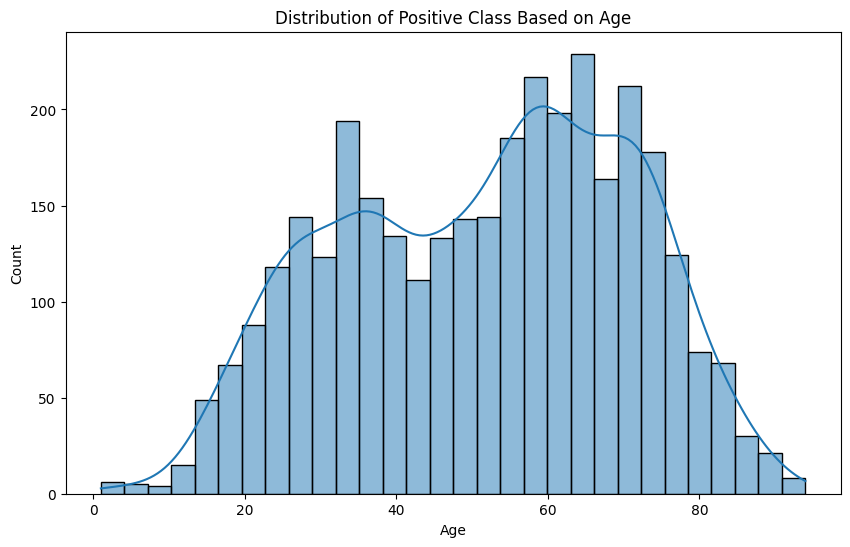

In [ ]:
positive_cases = df_eda[df_eda['thyroid_presence'] == 'P']

plt.figure(figsize=(10,6))
sns.histplot(data=positive_cases, x='age', bins=30, kde=True)
plt.title("Distribution of Positive Class Based on Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

We observe that most of the positive patients are female

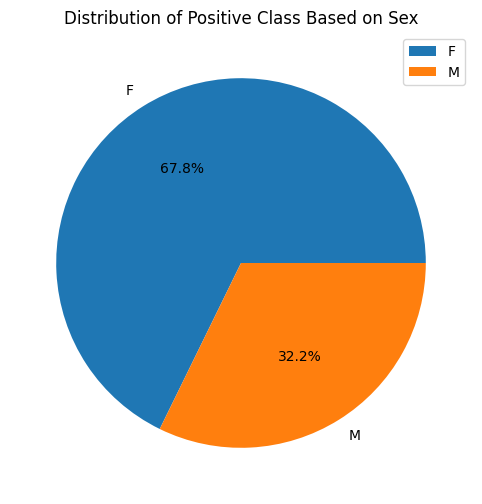

In [ ]:
# Getting the counts of each sex for positive class
counts = df_eda[df_eda['thyroid_presence'] == 'P']['sex'].value_counts()

#Pie Chart
plt.figure(figsize=(10,6))
counts.plot(kind='pie', autopct='%1.1f%%', legend=True)
plt.title("Distribution of Positive Class Based on Sex")
plt.ylabel("")
plt.show()


96% of patients were already sick

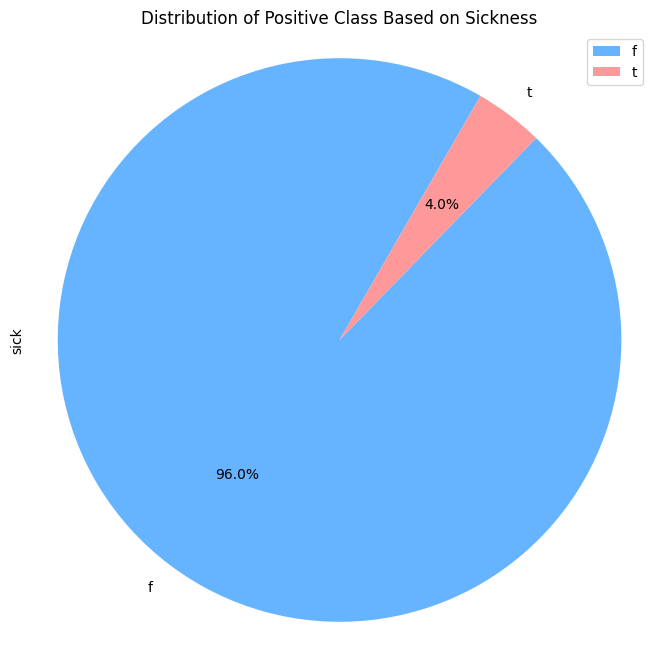

In [ ]:
df_eda[df_eda['thyroid_presence'] == 'P']['sick'].value_counts().plot(kind='pie', figsize=(8, 8), colors=['#66b3ff','#ff9999'], autopct='%1.1f%%', startangle=60).set_title('Distribution of Positive Class Based on Sickness')
plt.axis('equal')
plt.legend()
plt.show()

### We will examine the cross-distribution of each attribute concerning the presence or absence of thyroid.

In [ ]:
features = ['sex', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'lithium', 'goitre', 'tumor']

for feature in features:
    cross_tab = pd.crosstab(df_eda[feature], df_eda['thyroid_presence'])
    print(f"\nCross-tabulation between 'thyroid_presence' and '{feature}':")
    print(cross_tab)



Cross-tabulation between 'thyroid_presence' and 'sex':
thyroid_presence    N     P
sex                        
F                 215  2263
M                  65  1077

Cross-tabulation between 'thyroid_presence' and 'sick':
thyroid_presence    N     P
sick                       
f                 269  3208
t                  11   132

Cross-tabulation between 'thyroid_presence' and 'pregnant':
thyroid_presence    N     P
pregnant                   
f                 280  3289
t                   0    51

Cross-tabulation between 'thyroid_presence' and 'thyroid surgery':
thyroid_presence    N     P
thyroid surgery            
f                 278  3290
t                   2    50

Cross-tabulation between 'thyroid_presence' and 'I131 treatment':
thyroid_presence    N     P
I131 treatment             
f                 275  3291
t                   5    49

Cross-tabulation between 'thyroid_presence' and 'lithium':
thyroid_presence    N     P
lithium                    
f              

Box plot and pair plot for value distribution of features

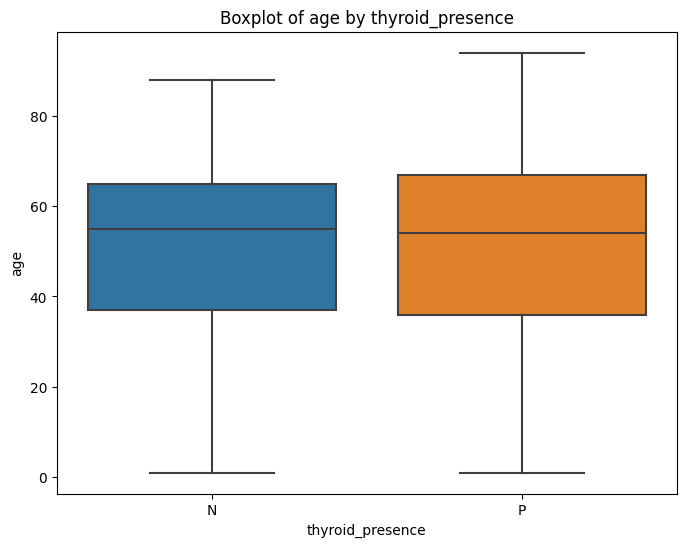

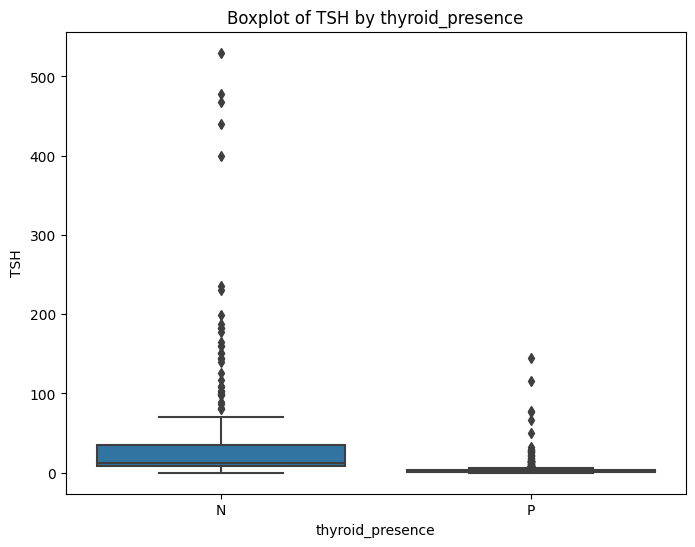

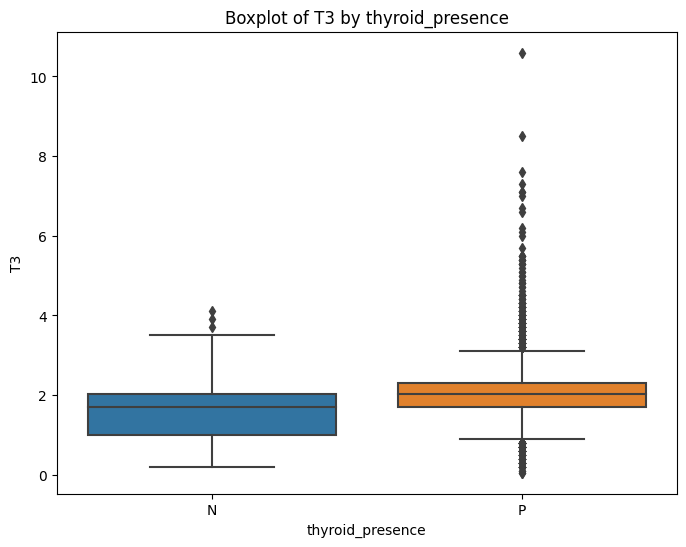

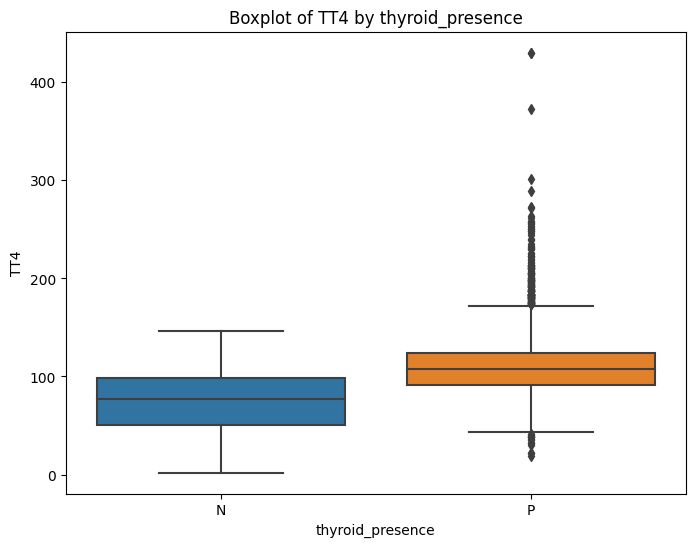

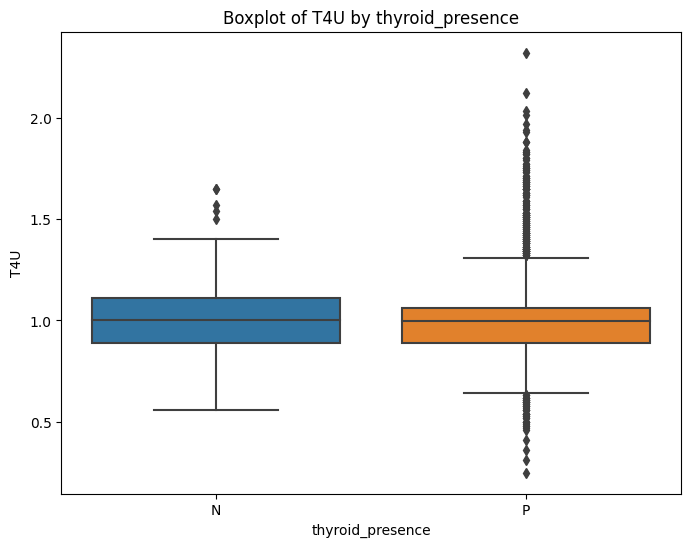

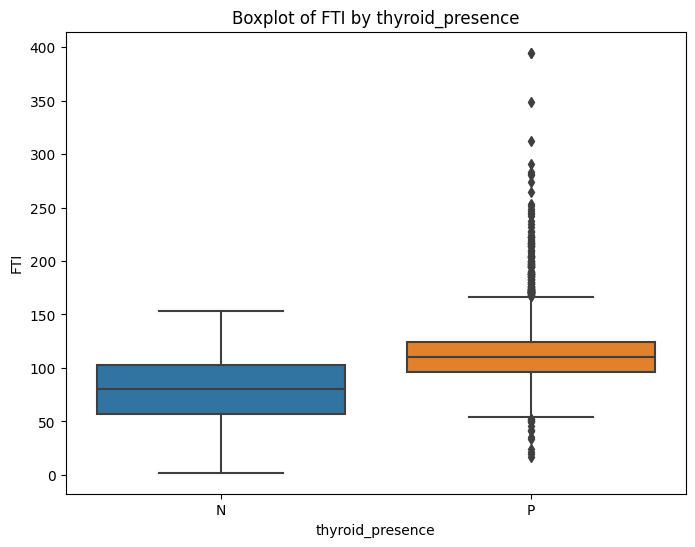

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define numeric fields
numeric_fields = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

# Creating boxplots
for field in numeric_fields:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='thyroid_presence', y=field, data=df_eda)
    plt.title(f'Boxplot of {field} by thyroid_presence')
    plt.show()


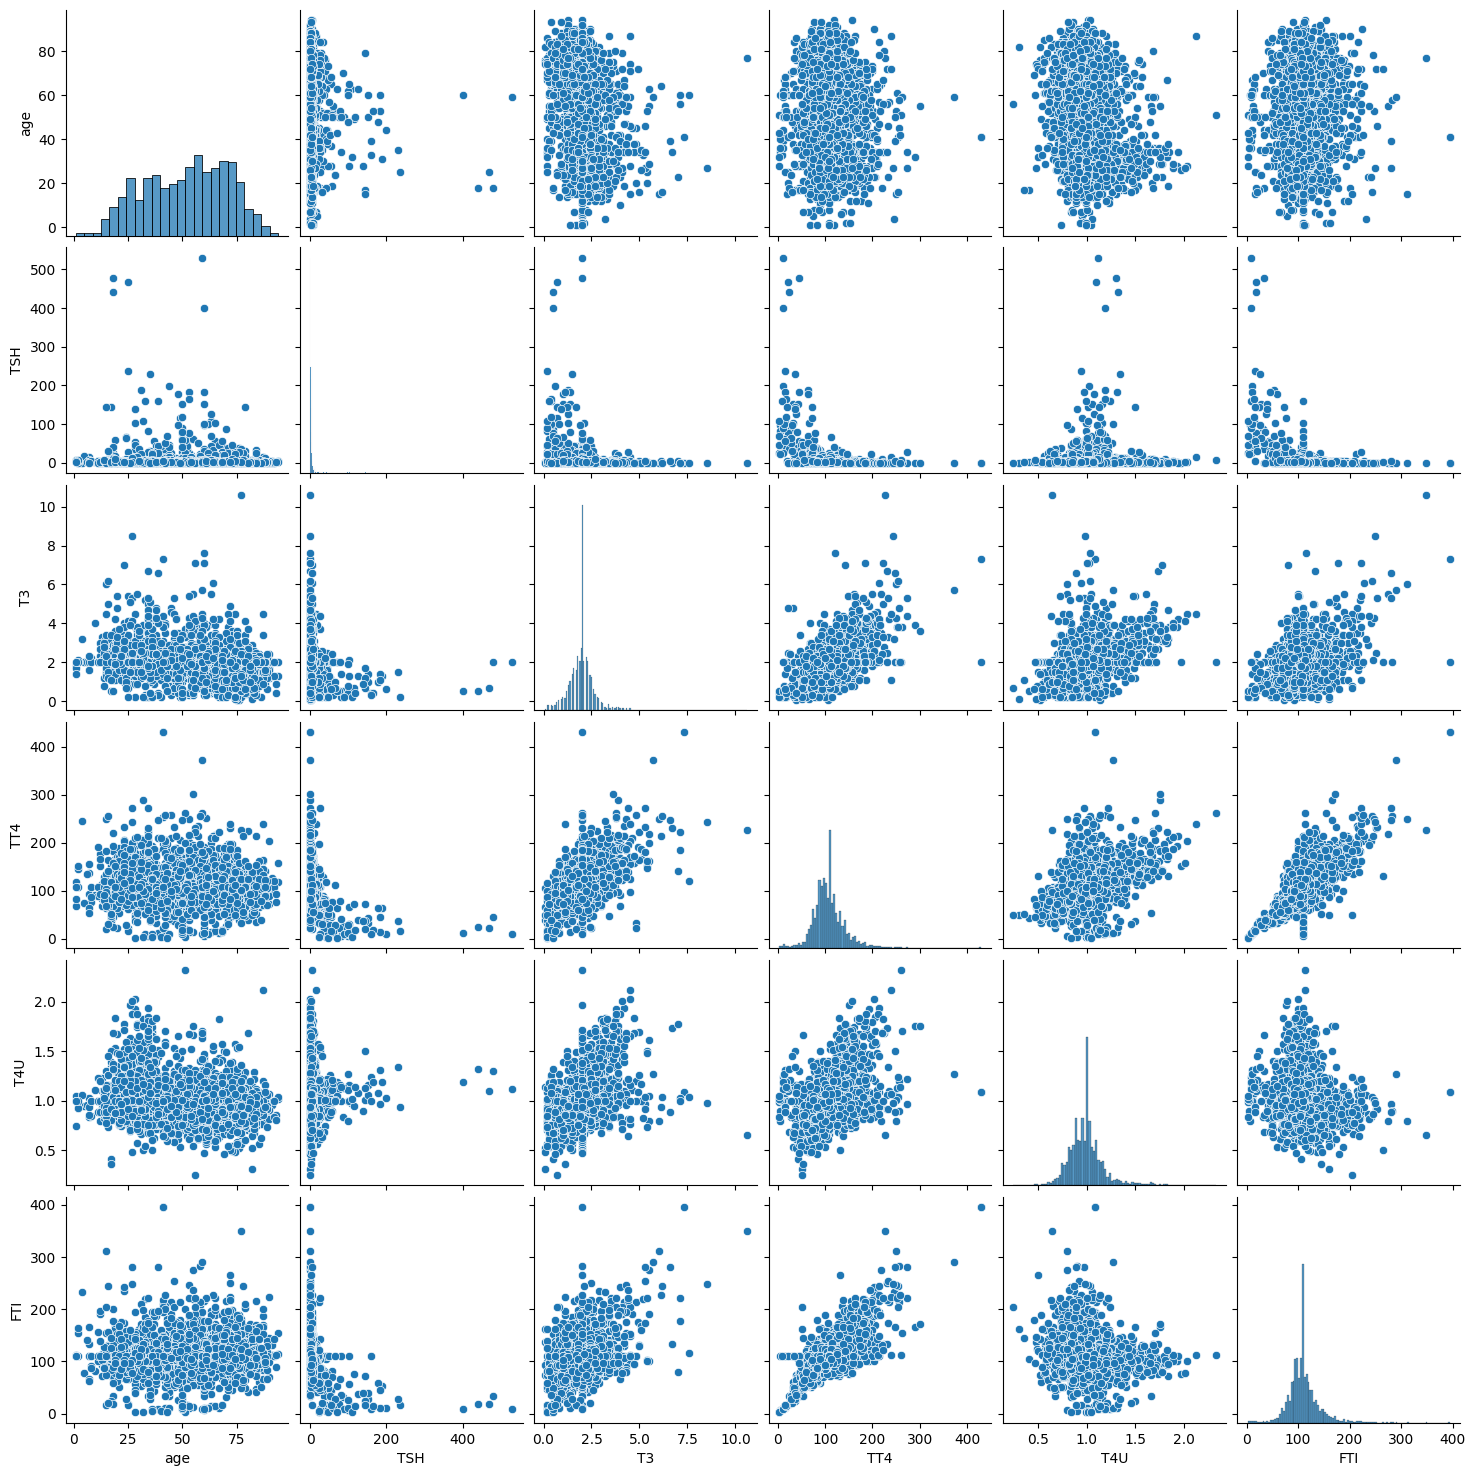

In [ ]:
import seaborn as sns

numeric_fields = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

# Pairplot
sns.pairplot(df_eda[numeric_fields])
plt.show()


In [ ]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620 entries, 0 to 3771
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               3620 non-null   int64   
 1   sex               3620 non-null   category
 2   sick              3620 non-null   category
 3   pregnant          3620 non-null   category
 4   thyroid surgery   3620 non-null   category
 5   I131 treatment    3620 non-null   category
 6   lithium           3620 non-null   category
 7   goitre            3620 non-null   category
 8   tumor             3620 non-null   category
 9   TSH               3620 non-null   float64 
 10  T3                3620 non-null   float64 
 11  TT4               3620 non-null   int64   
 12  T4U               3620 non-null   float64 
 13  FTI               3620 non-null   int64   
 14  thyroid_presence  3620 non-null   category
dtypes: category(9), float64(3), int64(3)
memory usage: 230.9 KB


To prepare dataset for model training, we'll encode 'category' type features to 'int' and prepare a new dataframe - df_encoded

In [ ]:
df_encoded = df_eda.copy()

# listing categorical columns
categorical_columns = df_encoded.select_dtypes(['category']).columns

# Looping over categorical columns and converting them to numerical
for col in categorical_columns:
    df_encoded[col] = df_encoded[col].cat.codes

Here we can see that we have encoded all the features to numerical values.

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620 entries, 0 to 3771
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3620 non-null   int64  
 1   sex               3620 non-null   int8   
 2   sick              3620 non-null   int8   
 3   pregnant          3620 non-null   int8   
 4   thyroid surgery   3620 non-null   int8   
 5   I131 treatment    3620 non-null   int8   
 6   lithium           3620 non-null   int8   
 7   goitre            3620 non-null   int8   
 8   tumor             3620 non-null   int8   
 9   TSH               3620 non-null   float64
 10  T3                3620 non-null   float64
 11  TT4               3620 non-null   int64  
 12  T4U               3620 non-null   float64
 13  FTI               3620 non-null   int64  
 14  thyroid_presence  3620 non-null   int8   
dtypes: float64(3), int64(3), int8(9)
memory usage: 229.8 KB


Splitting the feature set and target variable

In [ ]:
X = df_encoded.drop('thyroid_presence',axis=1)
y = df_encoded.thyroid_presence

In [ ]:
print(y.value_counts())

1    3340
0     280
Name: thyroid_presence, dtype: int64


As initially mentioned, our dataset exhibits class imbalance, with 3340 true and 280 false values. To address this, we'll use SMOTE (Synthetic Minority Over-sampling Technique), a method to balance the classes.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))


Training set size: 2896
Test set size: 724


#5. Oversampling with SMOTE
This section applies the Synthetic Minority Over-sampling Technique (SMOTE) to the training data to handle imbalanced classes.

In [ ]:
# smote = SMOTE(sampling_strategy='minority')
# X_sm, y_sm = smote.fit_resample(X, y)

In [ ]:
# print("Shape before the Oversampling : ",X_train.shape)
# print("Shape after the Oversampling : ",X_sm.shape)

In [ ]:
smote = SMOTE(random_state=42)

X_sm, Y_sm = smote.fit_resample(X_train, y_train)

In [ ]:
print("Shape before the Oversampling : ",X_train.shape)
print("Shape after the Oversampling : ",X_sm.shape)

Shape before the Oversampling :  (2896, 14)
Shape after the Oversampling :  (5350, 14)


In [ ]:
print(Y_sm.value_counts())

1    2675
0    2675
Name: thyroid_presence, dtype: int64


As you can see, classes are balanced now. We'll train models accordingly, performing a comparative analysis of models' performance with and without SMOT.

#6. Model Training

##1. RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Without SMOTE
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest performance:")
print(classification_report(y_test, y_pred_rf))

# With SMOTE
rf_smote = RandomForestClassifier()
rf_smote.fit(X_sm, Y_sm)

y_pred_rf_smote = rf_smote.predict(X_test)
print("Random Forest performance with SMOTE:")
print(classification_report(y_test, y_pred_rf_smote))


Random Forest performance:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        59
           1       0.99      0.98      0.99       665

    accuracy                           0.98       724
   macro avg       0.91      0.93      0.92       724
weighted avg       0.98      0.98      0.98       724

Random Forest performance with SMOTE:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        59
           1       1.00      0.98      0.99       665

    accuracy                           0.98       724
   macro avg       0.92      0.97      0.94       724
weighted avg       0.98      0.98      0.98       724



##2. XGBoost

In [ ]:
import xgboost as xgb

# Without SMOTE
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost performance:")
print(classification_report(y_test, y_pred_xgb))

# With SMOTE
xgb_smote = xgb.XGBClassifier()
xgb_smote.fit(X_sm, Y_sm)

y_pred_xgb_smote = xgb_smote.predict(X_test)
print("XGBoost performance with SMOTE:")
print(classification_report(y_test, y_pred_xgb_smote))


XGBoost performance:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        59
           1       0.99      0.98      0.99       665

    accuracy                           0.98       724
   macro avg       0.91      0.92      0.92       724
weighted avg       0.98      0.98      0.98       724

XGBoost performance with SMOTE:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        59
           1       0.99      0.98      0.99       665

    accuracy                           0.97       724
   macro avg       0.90      0.94      0.92       724
weighted avg       0.98      0.97      0.97       724



##3. Nerual Netwok

###a. Without SMOTE

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model_nsm = Sequential()
model_nsm.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model_nsm.add(Dense(8, activation='relu'))
model_nsm.add(Dense(1, activation='sigmoid'))

model_nsm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_nsm = model_nsm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=10)

_1, nsm_accuracy = model_nsm.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (nsm_accuracy*100))


Epoch 1/50
290/290 [==============================] - 2s 3ms/step - loss: 2.8626 - accuracy: 0.8008 - val_loss: 0.5673 - val_accuracy: 0.9130
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2399 - accuracy: 0.9334 - val_loss: 0.1937 - val_accuracy: 0.9448
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.1478 - accuracy: 0.9510 - val_loss: 0.1963 - val_accuracy: 0.9475
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.1384 - accuracy: 0.9561 - val_loss: 0.1705 - val_accuracy: 0.9503
Epoch 5/50
290/290 [==============================] - 1s 4ms/step - loss: 0.1362 - accuracy: 0.9575 - val_loss: 0.1645 - val_accuracy: 0.9558
Epoch 6/50
290/290 [==============================] - 1s 4ms/step - loss: 0.1341 - accuracy: 0.9568 - val_loss: 0.1520 - val_accuracy: 0.9530
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.1256 - accuracy: 0.9610 - val_loss: 0.1465 - val_accuracy: 0.9517
Epoch 

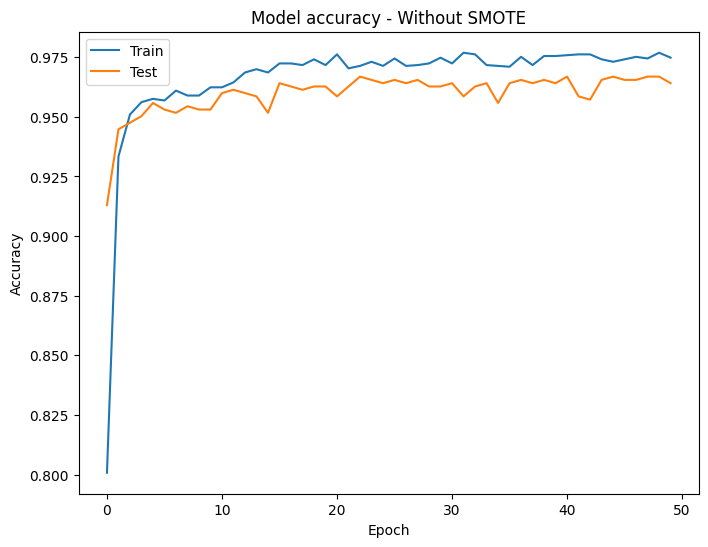

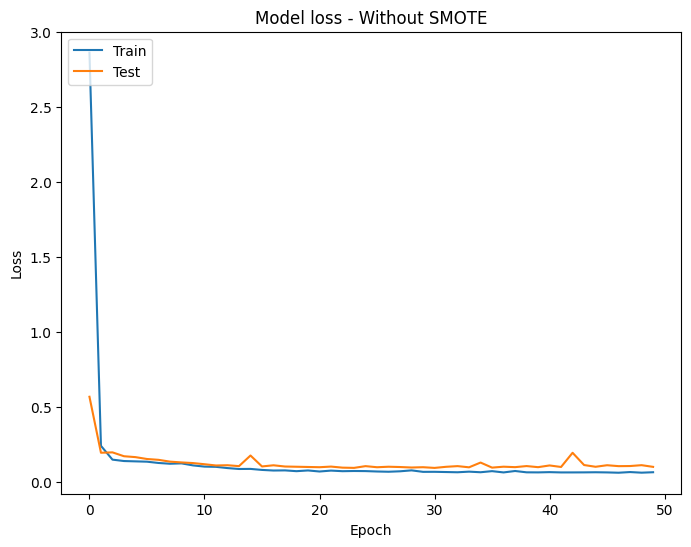

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history_nsm.history['accuracy'])
plt.plot(history_nsm.history['val_accuracy'])
plt.title('Model accuracy - Without SMOTE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(8,6))
plt.plot(history_nsm.history['loss'])
plt.plot(history_nsm.history['val_loss'])
plt.title('Model loss - Without SMOTE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##With SMOTE

In [ ]:

model_sm = Sequential()
model_sm.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model_sm.add(Dense(8, activation='relu'))
model_sm.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_sm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history_sm = model_sm.fit(X_sm, Y_sm, validation_data=(X_test, y_test), epochs=50, batch_size=10)

# Evaluating the model
_2, accuracy_sm = model_sm.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy_sm*100))


Epoch 1/50
535/535 [==============================] - 2s 2ms/step - loss: 1.2368 - accuracy: 0.7376 - val_loss: 0.4983 - val_accuracy: 0.8453
Epoch 2/50
535/535 [==============================] - 2s 3ms/step - loss: 0.2593 - accuracy: 0.9084 - val_loss: 0.1814 - val_accuracy: 0.9586
Epoch 3/50
535/535 [==============================] - 2s 3ms/step - loss: 0.1492 - accuracy: 0.9570 - val_loss: 0.2127 - val_accuracy: 0.9530
Epoch 4/50
535/535 [==============================] - 2s 3ms/step - loss: 0.1261 - accuracy: 0.9688 - val_loss: 0.1966 - val_accuracy: 0.9558
Epoch 5/50
535/535 [==============================] - 1s 2ms/step - loss: 0.1164 - accuracy: 0.9679 - val_loss: 0.2382 - val_accuracy: 0.9406
Epoch 6/50
535/535 [==============================] - 1s 2ms/step - loss: 0.1071 - accuracy: 0.9716 - val_loss: 0.1615 - val_accuracy: 0.9655
Epoch 7/50
535/535 [==============================] - 1s 2ms/step - loss: 0.1043 - accuracy: 0.9718 - val_loss: 0.1855 - val_accuracy: 0.9530
Epoch 

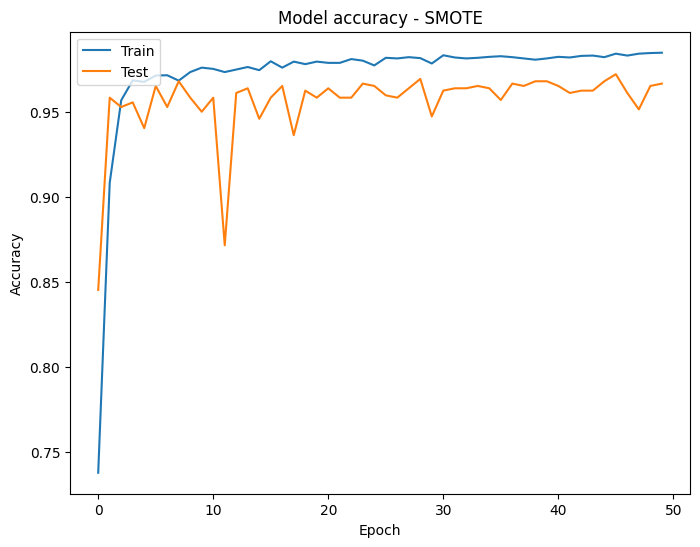

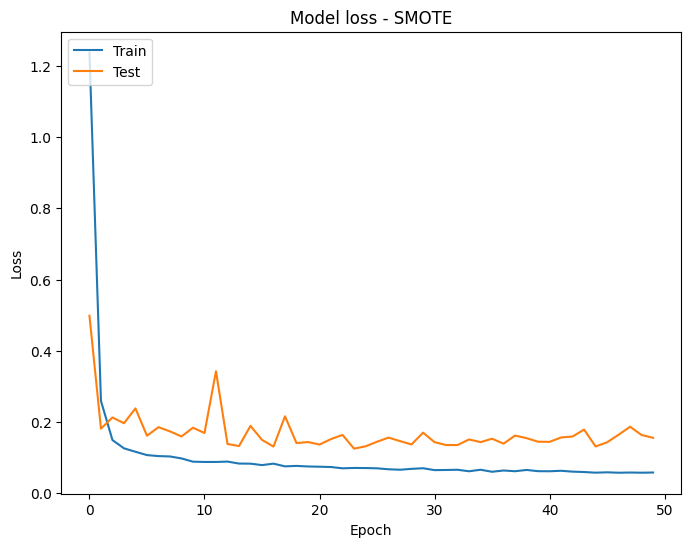

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history_sm.history['accuracy'])
plt.plot(history_sm.history['val_accuracy'])
plt.title('Model accuracy - SMOTE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(8,6))
plt.plot(history_sm.history['loss'])
plt.plot(history_sm.history['val_loss'])
plt.title('Model loss - SMOTE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

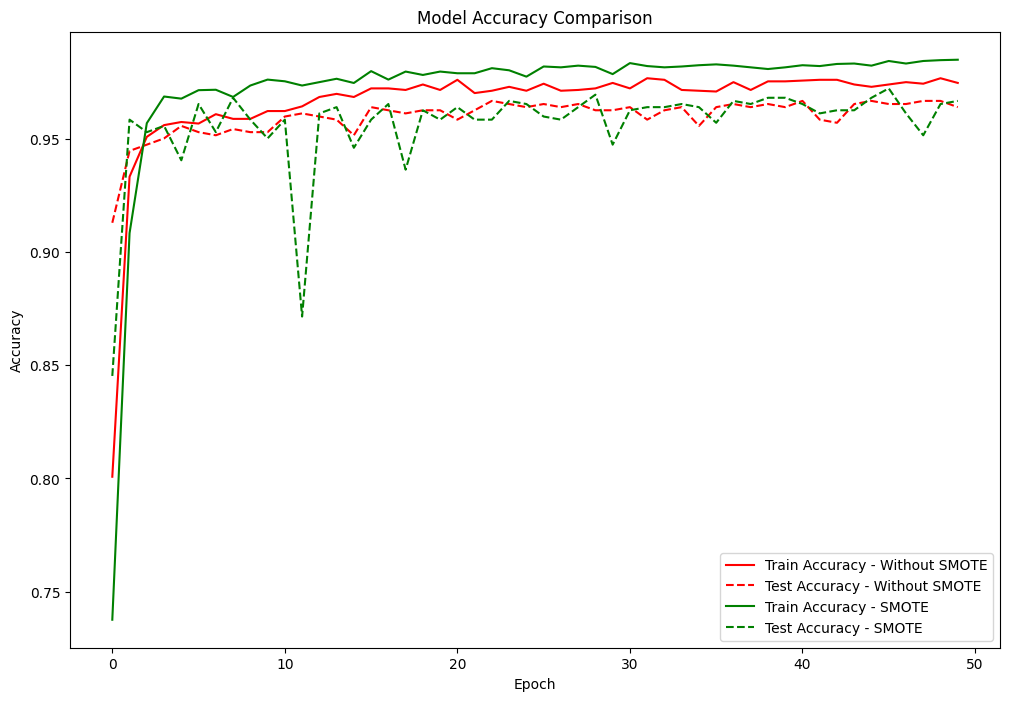

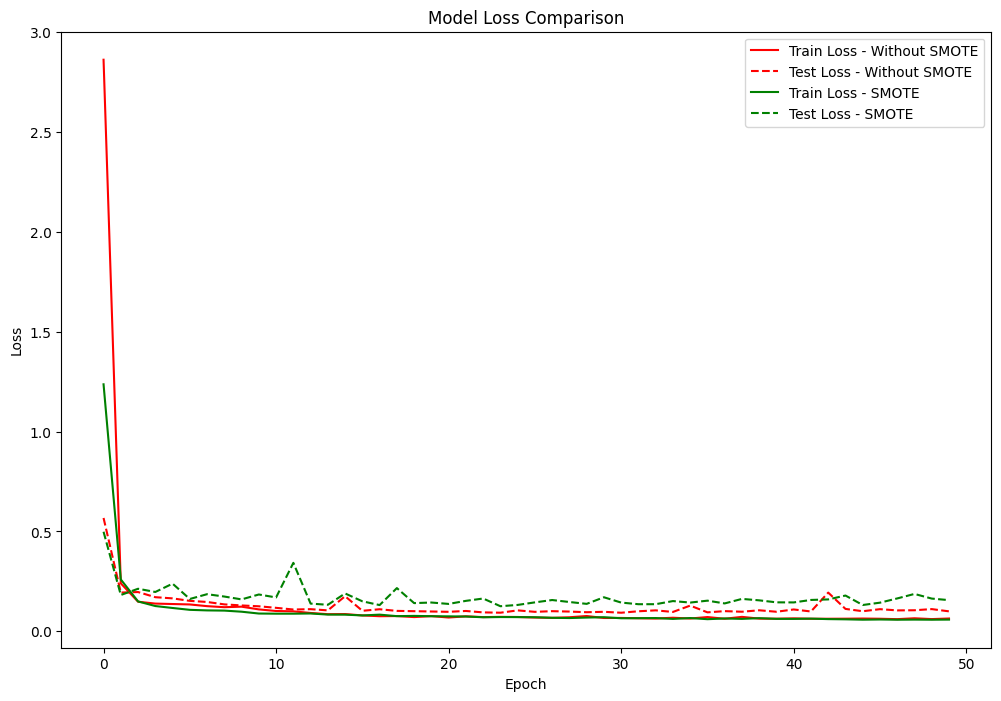

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12,8))
plt.plot(history_nsm.history['accuracy'], 'r', label='Train Accuracy - Without SMOTE')
plt.plot(history_nsm.history['val_accuracy'], 'r', linestyle='dashed', label='Test Accuracy - Without SMOTE')
plt.plot(history_sm.history['accuracy'], 'g', label='Train Accuracy - SMOTE')
plt.plot(history_sm.history['val_accuracy'], 'g', linestyle='dashed', label='Test Accuracy - SMOTE')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(12,8))
plt.plot(history_nsm.history['loss'], 'r', label='Train Loss - Without SMOTE')
plt.plot(history_nsm.history['val_loss'], 'r', linestyle='dashed', label='Test Loss - Without SMOTE')
plt.plot(history_sm.history['loss'], 'g', label='Train Loss - SMOTE')
plt.plot(history_sm.history['val_loss'], 'g', linestyle='dashed', label='Test Loss - SMOTE')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Get predictions from the neural networks
y_pred_nsm = (model_nsm.predict(X_test) > 0.5).flatten()
y_pred_sm = (model_sm.predict(X_test) > 0.5).flatten()

23/23 [==============================] - 0s 1ms/step


Observation: NN Model without smote exhibited a bit rough training behaviour than the model with SMOTE. Both Models accuracies are almost same.

#Ensemble Learning (Voting)
We will conduct ensemble learning using XGBoost (XGB) and Random Forest models to compare their performance in both SMOTE (Synthetic Minority Over-sampling Technique) and without SMOTE settings.

###Without SMOTE

In [ ]:
from sklearn.ensemble import VotingClassifier

# list of models
estimators=[('rf', rf), ('xgb', xgb_model)]

# Creating the ensemble model
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)

# Predicting on test data
y_pred_ens = ensemble.predict(X_test)
print("Ensemble performance:")
print(classification_report(y_test, y_pred_ens))


Ensemble performance:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        59
           1       1.00      0.98      0.99       665

    accuracy                           0.98       724
   macro avg       0.92      0.97      0.94       724
weighted avg       0.98      0.98      0.98       724



###With SMOTE

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators=[('rf', rf), ('xgb', xgb_model)]
ensemble = VotingClassifier(estimators, voting='hard')
# Using SMOTE dataset
ensemble.fit(X_sm, Y_sm)


y_pred_ens = ensemble.predict(X_test)
print("Ensemble performance:")
print(classification_report(y_test, y_pred_ens))


Ensemble performance:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        59
           1       1.00      0.98      0.99       665

    accuracy                           0.98       724
   macro avg       0.89      0.97      0.93       724
weighted avg       0.98      0.98      0.98       724



#Ensembled Learning (Stacking)

## Without SMOTE

In [ ]:
from sklearn.ensemble import StackingClassifier

# list of models
estimators=[('rf', rf), ('xgb', xgb_model)]

# Creating the ensemble model
stack = StackingClassifier(estimators)
stack.fit(X_train, y_train)

# Predicting on test data
y_pred_stack = stack.predict(X_test)
print("Stacking performance:")
print(classification_report(y_test, y_pred_stack))

Stacking performance:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        59
           1       0.99      0.99      0.99       665

    accuracy                           0.98       724
   macro avg       0.93      0.91      0.92       724
weighted avg       0.98      0.98      0.98       724



## SMOTE

In [ ]:
estimators=[('rf', rf), ('xgb', xgb_model)]
stack_smote = StackingClassifier(estimators)
# Using SMOTE dataset
stack_smote.fit(X_sm, Y_sm)

y_pred_stack_smote = stack_smote.predict(X_test)
print("Stacking performance with SMOTE:")
print(classification_report(y_test, y_pred_stack_smote))

Stacking performance with SMOTE:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        59
           1       0.99      0.98      0.99       665

    accuracy                           0.98       724
   macro avg       0.91      0.94      0.92       724
weighted avg       0.98      0.98      0.98       724



# Summarizing Comparative Analysis of All Models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

performance_dict = {}

# list of model names
model_names = ['Random Forest', 'Random Forest with SMOTE', 'XGBoost', 'XGBoost with SMOTE', 'Ensemble Voting', 'Ensemble Voting with SMOTE', 'Ensemble Stacking', 'Ensemble Stacking with SMOTE']

# list of predictions
predictions = [y_pred_rf, y_pred_rf_smote, y_pred_xgb, y_pred_xgb_smote, y_pred_ens, y_pred_ens,y_pred_stack, y_pred_stack_smote]

# Iterating through the models and populate the performance dictionary
for model, prediction in zip(model_names, predictions):
    report = classification_report(y_test, prediction, output_dict=True)
    performance_dict[model] = {
        'Accuracy': report['accuracy'],
        'Precision': report['macro avg']['precision'],
        'Recall': report['macro avg']['recall'],
        'F1-score': report['macro avg']['f1-score']
    }

# performance metrics for the neural networks
performance_dict['Neural Network'] = {
    'Accuracy': nsm_accuracy,
    'Precision': precision_score(y_test, y_pred_nsm, average='macro'),
    'Recall': recall_score(y_test, y_pred_nsm, average='macro'),
    'F1-score': f1_score(y_test, y_pred_nsm, average='macro')
}

performance_dict['Neural Network with SMOTE'] = {
    'Accuracy': accuracy_sm,
    'Precision': precision_score(y_test, y_pred_sm, average='macro'),
    'Recall': recall_score(y_test, y_pred_sm, average='macro'),
    'F1-score': f1_score(y_test, y_pred_sm, average='macro')
}


performance_df = pd.DataFrame(performance_dict).T

print(performance_df)

                              Accuracy  Precision    Recall  F1-score
Random Forest                 0.976519   0.914068  0.933159  0.923347
Random Forest with SMOTE      0.980663   0.915627  0.966306  0.939149
XGBoost                       0.975138   0.912000  0.924685  0.918223
XGBoost with SMOTE            0.973757   0.896956  0.939378  0.916819
Ensemble Voting               0.976519   0.894300  0.971773  0.928660
Ensemble Voting with SMOTE    0.976519   0.894300  0.971773  0.928660
Ensemble Stacking             0.976519   0.930015  0.909991  0.919710
Ensemble Stacking with SMOTE  0.976519   0.909517  0.940882  0.924479
Neural Network                0.964088   0.876196  0.887779  0.881878
Neural Network with SMOTE     0.966851   0.866023  0.943341  0.899972


#7. Feature Importance - using SHAP & LIME
Using random forest model instance, we're gonne explore the feature importance using SHAP and LIME

##SHAP

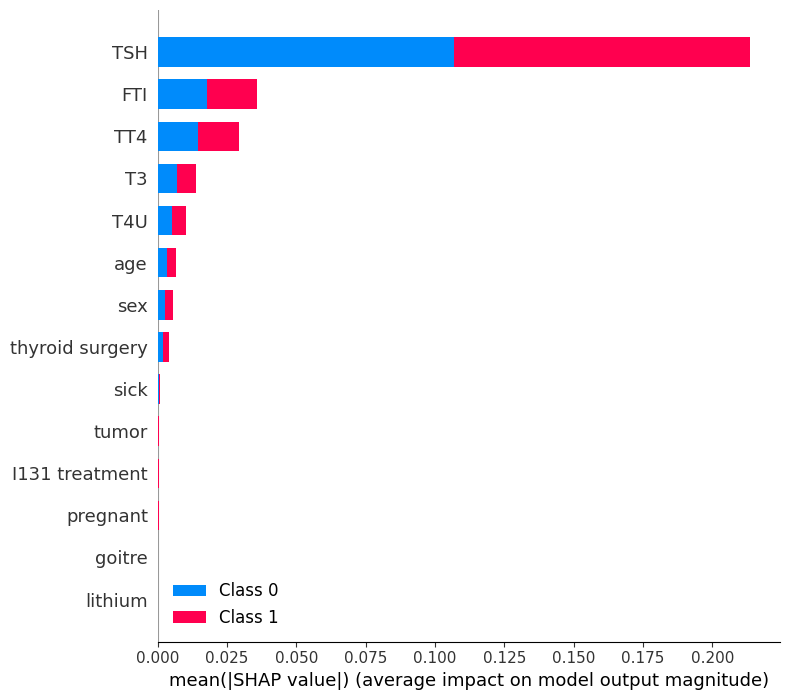

In [ ]:
import shap

# Creating a Tree explainer
explainer = shap.TreeExplainer(rf)
# Calculating shap values
shap_values = explainer.shap_values(X_train)
# Plotting shap values
shap.summary_plot(shap_values, X_train, plot_type="bar")


Using SHAP, we observe that TSH, FTI, and TT4 significantly influence the model's predictions. These three features stand out as the most crucial contributors in the thyroid classification dataset.

##LIME

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 1.050367658004522
Prediction_local [0.41244243]
Right: 1.0


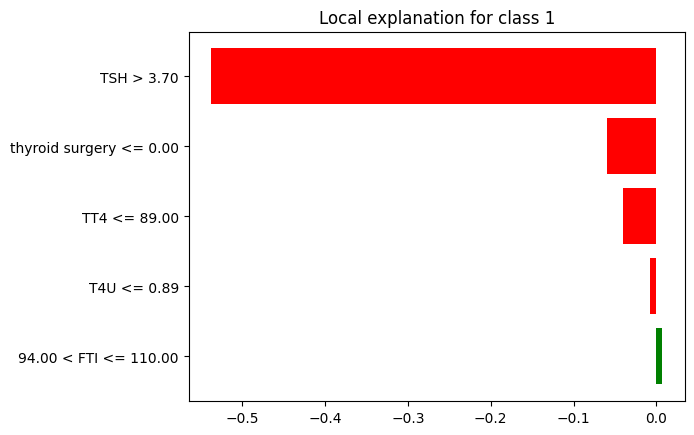

In [ ]:
import lime
import lime.lime_tabular

# LimeTabularExplainer object
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=['0','1'],
                                                   verbose=True,
                                                   mode='classification')

# Explaining a prediction
exp = explainer.explain_instance(X_test.iloc[0], rf.predict_proba, num_features=5, top_labels=1)


fig = exp.as_pyplot_figure()
plt.show()


Contrasting with SHAP, when employing LIME, TSH and TT4 retain their significance as important features. However, in this context, thyroid surgery displaces FTI from its previous second place among the top contributors.

#Comparing Feature Importance (Using Random Forest) with and without SMOTE
The feature_importances_ attribute in Random Forest provides a measure of how important each feature was in the construction of the random forests within the model. Here's a little more detail on how it works:

The Random Forest algorithm constructs many individual decision trees, and each tree will make a prediction. For regression tasks, this is the average prediction of the individual trees. For classification, this is the majority (mode) class predicted by the individual trees.

In each tree, the probability of reaching a node depends on the number of samples that reach the node, divided by the total number of samples. The higher this proportion, the more important the associated feature.

Feature importance in Random Forest is calculated as follows:

1. Train each tree in the forest using a bootstrap sample from the training data.
2. At each node in the tree, randomly select a set of features and determine the best split.
3. When the best split is determined by a feature, calculate the reduction in impurity (Gini impurity or entropy for classification, variance for regression) as a result of this split. This gives a measure of the importance of the feature.

This importance calculation is carried out for each node in the forest that is split on this feature, then averaged across trees to give a measure of the mean decrease in impurity, which is the feature importance score.

###Importance Values of each feature

In [ ]:
features = X_train.columns.tolist()
# get importance
importance = rf.feature_importances_
importance_smote = rf_smote.feature_importances_

# create a dataframe for easy sorting
importance_df = pd.DataFrame({'feature': features, 'importance': importance})
importance_smote_df = pd.DataFrame({'feature': features, 'importance_smote': importance_smote})

# sort the dataframes
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_smote_df = importance_smote_df.sort_values(by='importance_smote', ascending=False)

# print sorted importance
print('Importance Value - Without SMOTE \n')
for i in range(len(importance_df)):
    print('Feature: %s, Score: %.5f' % (importance_df.iloc[i]['feature'], importance_df.iloc[i]['importance']))

print('\nImportance Value - With SMOTE ')
for i in range(len(importance_smote_df)):
    print('Feature: %s, Score: %.5f' % (importance_smote_df.iloc[i]['feature'], importance_smote_df.iloc[i]['importance_smote']))


Importance Value - Without SMOTE 

Feature: TSH, Score: 0.60998
Feature: FTI, Score: 0.12895
Feature: TT4, Score: 0.10320
Feature: T3, Score: 0.04853
Feature: T4U, Score: 0.04199
Feature: age, Score: 0.04086
Feature: thyroid surgery, Score: 0.01276
Feature: sex, Score: 0.00732
Feature: sick, Score: 0.00209
Feature: tumor, Score: 0.00185
Feature: I131 treatment, Score: 0.00139
Feature: goitre, Score: 0.00043
Feature: pregnant, Score: 0.00042
Feature: lithium, Score: 0.00026

Importance Value - With SMOTE 
Feature: TSH, Score: 0.68063
Feature: FTI, Score: 0.09803
Feature: TT4, Score: 0.08222
Feature: T3, Score: 0.05888
Feature: sex, Score: 0.03155
Feature: T4U, Score: 0.02133
Feature: age, Score: 0.01549
Feature: thyroid surgery, Score: 0.00391
Feature: sick, Score: 0.00313
Feature: tumor, Score: 0.00233
Feature: pregnant, Score: 0.00149
Feature: I131 treatment, Score: 0.00046
Feature: goitre, Score: 0.00038
Feature: lithium, Score: 0.00016


<BarContainer object of 14 artists>

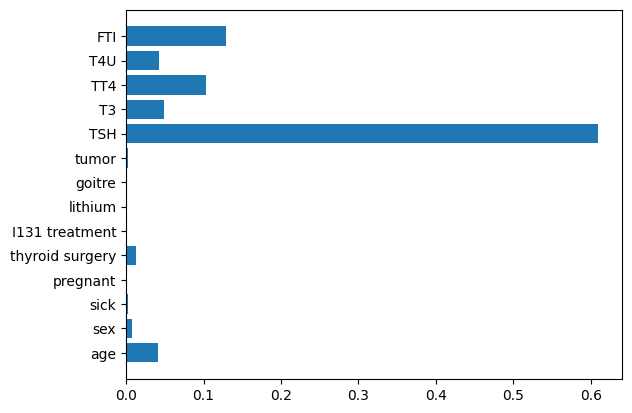

In [ ]:
plt.barh(df_encoded.columns[:-1], importance)

<BarContainer object of 14 artists>

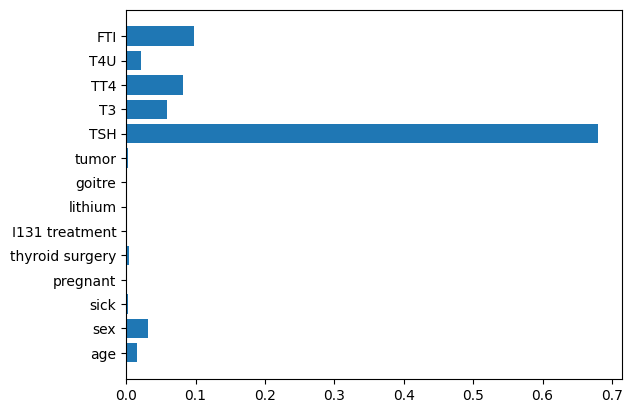

In [ ]:
plt.barh(df_encoded.columns[:-1], importance_smote)

We can see the difference in order of feature importance in both settings